# Import Libraries

In [1]:
%%capture
!pip install pyDOE

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from pyDOE import lhs
import matplotlib.pyplot as plt
from torch.utils.checkpoint import checkpoint

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

if device == 'cuda': print(torch.cuda.get_device_name())

cuda


# Physics Informed Neural Network

In [3]:
class PINN(nn.Module):
    def __init__(self, layers, ub, lb, hbar=1.0, m=1.0, g=1.0):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        self.ub = torch.tensor(ub, dtype=torch.float32, device=device)
        self.lb = torch.tensor(lb, dtype=torch.float32, device=device)

        # Learnable scaling for boundary conditions and Riesz energy
        self.adaptive_bc_scale = nn.Parameter(torch.tensor(1.0, device=device))
        self.adaptive_riesz_scale = nn.Parameter(torch.tensor(1.0, device=device))
        self.hbar = hbar
        self.m = m
        self.g = g

        # Define network layers with sine activation (improving smoothness for wave problems)
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                self.layers.append(nn.SiLU())  # Swapped to sine-based activation

        self.init_weights()

    def init_weights(self):
        for m in self.layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)

    def forward(self, x):
        lb = self.lb.view(1, -1)
        ub = self.ub.view(1, -1)
        x = (x - lb) / (ub - lb)

        # Apply gradient checkpointing to all layers
        for layer in self.layers:
            x = checkpoint(layer, x, use_reentrant=False)
        return x

    def loss_BC(self, x_bc, y_bc):
        u_pred = self.forward(x_bc)
        y_bc = torch.zeros_like(y_bc)
        adaptive_scale = self.adaptive_bc_scale
        # Introduce soft boundary constraint
        weight = torch.exp(-torch.norm(x_bc, dim=1))
        bc_loss = adaptive_scale * torch.mean(weight * (u_pred - y_bc) ** 2)
        return bc_loss

    def riesz_loss(self, predictions, inputs):
        psi = predictions
        if not inputs.requires_grad:
            inputs = inputs.clone().detach().requires_grad_(True)
        gradients = torch.autograd.grad(outputs=predictions, inputs=inputs,
                                        grad_outputs=torch.ones_like(predictions),
                                        create_graph=True, retain_graph=True)[0]
        riesz_energy = self.adaptive_riesz_scale * torch.mean(torch.sum(gradients ** 2) + 0.5 * self.g * psi ** 4)
        return riesz_energy

    def pde_loss(self, inputs, predictions):
        psi = predictions
        psi_x = torch.autograd.grad(psi, inputs, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
        psi_xx = torch.autograd.grad(psi_x[:, 0], inputs, grad_outputs=torch.ones_like(psi_x[:, 0]), create_graph=True)[0][:, 0]
        psi_yy = torch.autograd.grad(psi_x[:, 1], inputs, grad_outputs=torch.ones_like(psi_x[:, 1]), create_graph=True)[0][:, 1]
        laplacian_psi = psi_xx + psi_yy
        pde_residual = -laplacian_psi + self.g * torch.abs(psi) ** 2 * psi
        pde_loss = torch.mean(pde_residual ** 2)
        return pde_loss

    def loss(self, x_bc, y_bc, x_to_train_f):
        loss_u = self.adaptive_bc_scale * self.loss_BC(x_bc, y_bc)
        predictions = self.forward(x_to_train_f)
        loss_pde = self.pde_loss(x_to_train_f, predictions)
        loss_k = self.riesz_loss(predictions, x_to_train_f)
        total_loss = loss_u + loss_pde + loss_k
        return total_loss.mean()  # Normalized across points

    def get_ground_state(self, x):
        u = self.forward(x)
        energy = self.pde_loss(x, u)
        return u, energy.item()

# Prepare Training Data

In [4]:
def prepare_training_data(N_u, N_f, lb, ub, usol, X, Y):
    """
    Prepare boundary condition data and collocation points for training.

    Parameters
    ----------
    N_u : int
        Number of boundary condition points to select.
    N_f : int
        Number of collocation points for the physics-informed model.
    lb : np.Tensor
        Lower bound of the domain.
    ub : np.Tensor
        Upper bound of the domain.
    usol : np.Tensor
        Analytical solution of the PDE.
    X : np.Tensor
        X grid of points.
    Y : np.Tensor
        Y grid of points.

    Returns
    -------
    X_f_train : np.Tensor
        Combined collocation points and boundary points as training data.
    X_u_train : np.Tensor
        Selected boundary condition points.
    u_train : np.Tensor
        Corresponding boundary condition values.
    """

    # Extract boundary points and values from all four edges
    leftedge_x = np.hstack((X[:, 0][:, None], Y[:, 0][:, None]))
    leftedge_u = usol[:, 0][:, None] # 1D array of all zeros

    rightedge_x = np.hstack((X[:, -1][:, None], Y[:, -1][:, None]))
    rightedge_u = usol[:, -1][:, None] # 1D array of all zeros

    topedge_x = np.hstack((X[0, :][:, None], Y[0, :][:, None]))
    topedge_u = usol[0, :][:, None] # 1D array of all zeros

    bottomedge_x = np.hstack((X[-1, :][:, None], Y[-1, :][:, None]))
    bottomedge_u = usol[-1, :][:, None] # 1D array of all zeros

    # Combine all edge points
    all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x])
    all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])

    # Randomly select N_u points from boundary
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False)

    # Select the corresponding training points and u values
    X_u_train = all_X_u_train[idx[0:N_u], :]  # Boundary points (x, t)
    u_train = all_u_train[idx[0:N_u], :]      # Corresponding u values

    # Generate N_f collocation points using Latin Hypercube Sampling
    X_f = lb + (ub - lb) * lhs(2, N_f)  # Generates points in the domain [lb, ub]

    # Combine collocation points with boundary points
    X_f_train = np.vstack((X_f, X_u_train))

    return X_f_train, X_u_train, u_train

# Training PINN

In [5]:
def train_pinn_mixed_precision(model, optimizer, scheduler, x_bc, y_bc, x_to_train_f, epochs):
    """
    Training loop for the PINN model with mixed precision.

    Parameters
    ----------
    model : PINN
        PINN model to be trained.
    optimizer : torch.optim.Optimizer
        Optimizer for training.
    scheduler : torch.optim.lr_scheduler
        Learning rate scheduler.
    x_bc : torch.Tensor
        Boundary condition input data.
    y_bc : torch.Tensor
        Boundary condition output data.
    x_to_train_f : torch.Tensor
        Input points for PDE training.
    epochs : int
        Number of training epochs.
    """

    scaler = torch.amp.GradScaler('cuda')  # Mixed precision training
    energy_progress = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):  # Use mixed precision for forward pass
            loss = model.loss(x_bc, y_bc, x_to_train_f)

        # Make loss a scalar
        #loss = loss.mean() #  average of all individual losses
        loss = loss.sum() # total sum of all losses.

        scaler.scale(loss).backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()
        scheduler.step(loss)

        if epoch % 100 == 0:
            print(f'Epoch: {epoch}/{epochs}, '
                  f'Loss: {loss.item()}, '
                  f'hbar: {model.hbar}, '
                  f'm: {model.m.real}, '
                  f'g: {model.g.real}, '
                  f'Adaptive BC: {model.adaptive_bc_scale.item()}')

        # Get the lowest energy ground state after each epoch
        u, energy = model.get_ground_state(x_to_train_f)
        energy_progress.append(energy)

    # Plot energy progress
    plot_energy_progress(energy_progress)

# Training PINN Hybrid

In [6]:
def train_pinn_hybrid(model, adam_optimizer, lbfgs_optimizer, scheduler, x_bc, y_bc, x_to_train_f, epochs_adam, epochs_lbfgs):
    scaler = torch.cuda.amp.GradScaler()
    x_bc, y_bc, x_to_train_f = [x.requires_grad_(True) for x in [x_bc, y_bc, x_to_train_f]]

    for epoch in range(epochs_adam):
        model.train()
        adam_optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            loss = model.loss(x_bc, y_bc, x_to_train_f)

        scaler.scale(loss).backward()
        scaler.step(adam_optimizer)
        scaler.update()
        scheduler.step(loss)

        if epoch % 100 == 0:
            print(f'Epoch {epoch}/{epochs_adam} - Loss: {loss.item()}')

    def closure():
        lbfgs_optimizer.zero_grad()
        loss = model.loss(x_bc, y_bc, x_to_train_f)
        loss.backward()
        return loss

    for _ in range(epochs_lbfgs):
        lbfgs_optimizer.step(closure)

# *Solution Plot*

In [7]:
def visualize_solution(model, x_train, y_train):
    """
    Visualizes the predicted solution from the Physics-Informed Neural Network (PINN).

    The plot shows the network's predicted solution over the 2D spatial domain.

    Parameters
    ----------
    model : PINN
        The trained PINN model used for predictions.
    x_train : torch.Tensor
        Training points used for prediction. Should be a tensor of shape (N, 1).
    y_train : torch.Tensor
        Training points used for prediction. Should be a tensor of shape (N, 1).
    """
    # Flatten the grid of x_train and y_train
    x_flat = x_train.reshape(-1, 1)
    y_flat = y_train.reshape(-1, 1)

    # Generate predictions using the model
    with torch.no_grad():  # Don't track gradients for visualization
        inputs = torch.cat([x_flat, y_flat], dim=1)  # Combine x and y into a 2D tensor
        u_pred = model(inputs)  # Get the model's predictions

    # Detach the predictions and convert to numpy
    x_train = x_train.detach().cpu().numpy()
    y_train = y_train.detach().cpu().numpy()
    u_pred = u_pred.detach().cpu().numpy().reshape(x_train.shape)

    # Create a grid
    x_unique = np.unique(x_train)
    y_unique = np.unique(y_train)
    X, Y = np.meshgrid(x_unique, y_unique)

    # Plotting the predicted solution
    fig, ax = plt.subplots(figsize=(8, 6))

    # Surface plot of predicted solution
    c = ax.pcolor(X, Y, u_pred, cmap='jet')
    fig.colorbar(c, ax=ax)

    ax.set_xlabel(r'$x$ (Spatial Coordinate)', fontsize=12)
    ax.set_ylabel(r'$y$ (Spatial Coordinate)', fontsize=12)

    ax.set_title('Predicted Solution from PINN after Training\n(Prediction over the Spatial Domain)', fontsize=14)
    plt.tight_layout()
    plt.show()

# Cosine Scheduler

In [8]:
def create_cosine_scheduler(optimizer, T_max):
    return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

# Energy Progress

In [9]:
def plot_energy_progress(energy_list):
    """
    Plots the energy progress over training.

    Parameters
    ----------
    energy_list : list
        List of energy values recorded during training.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(energy_list, label='Lowest Energy')
    plt.xlabel('Epochs')
    plt.ylabel('Energy')
    plt.title('Lowest Energy Ground State During Training')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Ground State 2D

In [10]:
def plot_ground_state_2d(model, x_train, y_train):
    """
    Plots the lowest energy ground state in 2D as a color map.

    Parameters
    ----------
    model : PINN
        The trained PINN model used for predictions.
    x_train : torch.Tensor
        X coordinates of the points to plot.
    y_train : torch.Tensor
        Y coordinates of the points to plot.
    """
    # Flatten the grid of x_train and y_train
    x_flat = x_train.reshape(-1, 1)
    y_flat = y_train.reshape(-1, 1)

    # Generate predictions using the model
    with torch.no_grad():  # Don't track gradients for visualization
        inputs = torch.cat([x_flat, y_flat], dim=1)  # Combine x and y into a 2D tensor
        u_pred = model(inputs)  # Get the model's predictions

    # Detach the predictions and convert to numpy
    x_train = x_train.detach().cpu().numpy()
    y_train = y_train.detach().cpu().numpy()
    u_pred = u_pred.detach().cpu().numpy().reshape(x_train.shape)

    # Create a grid
    x_unique = np.unique(x_train)
    y_unique = np.unique(y_train)
    X, Y = np.meshgrid(x_unique, y_unique)

    # Plotting the ground state as a 2D color map
    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, u_pred, cmap='jet')
    plt.colorbar(label='Ground State Wave Function (u)')
    plt.xlabel('X (Spatial Coordinate)')
    plt.ylabel('Y (Spatial Coordinate)')
    plt.title('Lowest Energy Ground State (2D)')
    plt.show()


# Plot Ground State 3D

In [11]:
def plot_ground_state_3d(model, x_train, y_train):
    """
    Plots the lowest energy ground state in 3D.

    Parameters
    ----------
    model : PINN
        The trained PINN model used for predictions.
    x_train : torch.Tensor
        X coordinates of the points to plot.
    y_train : torch.Tensor
        Y coordinates of the points to plot.
    """
    # Flatten the grid of x_train and y_train
    x_flat = x_train.reshape(-1, 1)
    y_flat = y_train.reshape(-1, 1)

    # Generate predictions using the model
    with torch.no_grad():  # Don't track gradients for visualization
        inputs = torch.cat([x_flat, y_flat], dim=1)  # Combine x and y into a 2D tensor
        u_pred = model(inputs)  # Get the model's predictions

    # Detach the predictions and convert to numpy
    x_train = x_train.detach().cpu().numpy()
    y_train = y_train.detach().cpu().numpy()
    u_pred = u_pred.detach().cpu().numpy().reshape(x_train.shape)

    # Create a grid
    x_unique = np.unique(x_train)
    y_unique = np.unique(y_train)
    X, Y = np.meshgrid(x_unique, y_unique)

    # Plotting the ground state as a 3D surface plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Surface plot
    ax.plot_surface(X, Y, u_pred, cmap='viridis')

    ax.set_xlabel('X (Spatial Coordinate)')
    ax.set_ylabel('Y (Spatial Coordinate)')
    ax.set_zlabel('Ground State Wave Function (u)')
    ax.set_title('Lowest Energy Ground State (3D)')

    plt.show()

# Visualize Solution

In [12]:
def visualize_solution(model, x_train, y_train):
    """
    Visualizes the predicted solution from the Physics-Informed Neural Network (PINN).

    The plot shows the network's predicted solution over the 2D spatial domain.

    Parameters
    ----------
    model : PINN
        The trained PINN model used for predictions.
    x_train : torch.Tensor
        Training points used for prediction. Should be a tensor of shape (N, 1).
    y_train : torch.Tensor
        Training points used for prediction. Should be a tensor of shape (N, 1).
    """
    # Flatten the grid of x_train and y_train
    x_flat = x_train.reshape(-1, 1)
    y_flat = y_train.reshape(-1, 1)

    # Generate predictions using the model
    with torch.no_grad():  # Don't track gradients for visualization
        inputs = torch.cat([x_flat, y_flat], dim=1)  # Combine x and y into a 2D tensor
        u_pred = model(inputs)  # Get the model's predictions

    # Detach the predictions and convert to numpy
    x_train = x_train.detach().cpu().numpy()
    y_train = y_train.detach().cpu().numpy()
    u_pred = u_pred.detach().cpu().numpy().reshape(x_train.shape)

    # Create a grid
    x_unique = np.unique(x_train)
    y_unique = np.unique(y_train)
    X, Y = np.meshgrid(x_unique, y_unique)

    # Plotting the predicted solution
    fig, ax = plt.subplots(figsize=(8, 6))

    # Surface plot of predicted solution
    c = ax.pcolor(X, Y, u_pred, cmap='jet')
    fig.colorbar(c, ax=ax)

    ax.set_xlabel(r'$x$ (Spatial Coordinate)', fontsize=12)
    ax.set_ylabel(r'$y$ (Spatial Coordinate)', fontsize=12)

    ax.set_title('Predicted Solution from PINN after Training\n(Prediction over the Spatial Domain)', fontsize=14)
    plt.tight_layout()
    plt.show()

# Main

In [13]:
# Grid, lower and upper bounds
X, Y = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
lb = np.array([0, 0])
ub = np.array([1, 1])

# Initialize usol with zeros at the boundary
usol = np.zeros_like(X)

# Flatten the solution
u_true = usol.flatten()[:, None]

# Flatten the grids and stack them into a 2D array
X_u_test = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

N_u = 100  # Number of boundary points
N_f = 1000  # Number of collocation points
X_f_train_np_array, X_u_train_np_array, u_train_np_array = prepare_training_data(N_u, N_f, lb, ub, usol, X, Y)

# Training data with boundary condition points
x_train = torch.linspace(0.0, 1.0, 100, device=device).view(-1, 1).requires_grad_(True)
y_train = torch.linspace(0.0, 1.0, 100, device=device).view(-1, 1).requires_grad_(True)
x_train, y_train = torch.meshgrid(x_train.squeeze(), y_train.squeeze(), indexing='ij')
x_bc, y_bc = x_train.reshape(-1, 1), y_train.reshape(-1, 1)

# Convert numpy arrays to PyTorch tensors and move to GPU (if available)
X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)  # Collocation points
X_u_train = torch.from_numpy(X_u_train_np_array).float().to(device)  # Boundary condition points
u_train = torch.from_numpy(u_train_np_array).float().to(device)  # Boundary condition values
X_u_test_tensor = torch.from_numpy(X_u_test).float().to(device)  # Test data for boundary conditions
u = torch.from_numpy(u_true).float().to(device)  # True solution values (ground truth for testing)
f_hat = torch.zeros(X_f_train.shape[0], 1).to(device)  # Zero tensor for the physics equation residual

# Model parameters
layers = [2, 40, 40, 40, 40, 1]  # Neural network layers
epochs = 1000

# Initialize model with bounds and layer structure
model = PINN(layers, ub=ub, lb=lb).to(device)

# Optimizers and Scheduler
adam_optimizer = optim.Adam(model.parameters(), lr=0.01)
lbfgs_optimizer = optim.LBFGS(model.parameters(), max_iter=500, history_size=100)

# Cosine annealing scheduler for Adam optimizer
scheduler = create_cosine_scheduler(adam_optimizer, T_max=1000)

# Train the model
train_pinn_hybrid(model, adam_optimizer, lbfgs_optimizer, scheduler, x_bc, y_bc, X_f_train, epochs_adam=1000,
                  epochs_lbfgs=500)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://githu

Epoch 0/1000 - Loss: 0.20189207792282104
Epoch 100/1000 - Loss: 8.893415724742226e-06
Epoch 200/1000 - Loss: 1.1111924322904088e-06
Epoch 300/1000 - Loss: 9.636842150939628e-07
Epoch 400/1000 - Loss: 8.212024908971216e-07
Epoch 500/1000 - Loss: 7.244818789331475e-07
Epoch 600/1000 - Loss: 0.00014323313371278346
Epoch 700/1000 - Loss: 6.319580165836669e-07
Epoch 800/1000 - Loss: 7.741324452581466e-07
Epoch 900/1000 - Loss: 2.5722562213559286e-07


# Plots

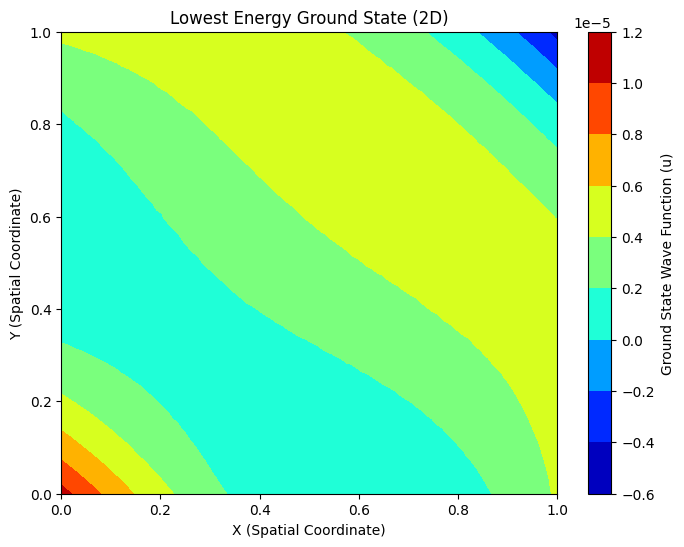

In [14]:
# Return lowest energy ground state (u as a vector and lambda as a scalar) and plot values
plot_ground_state_2d(model, x_train, y_train)

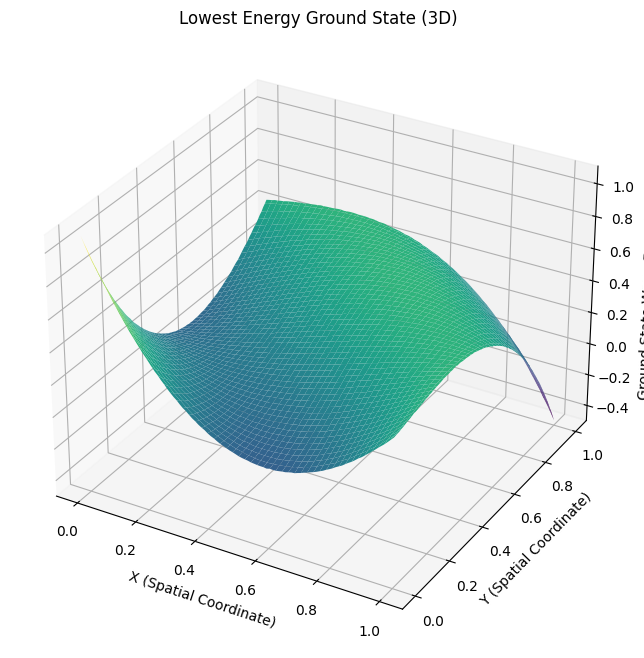

In [15]:
plot_ground_state_3d(model, x_train, y_train)

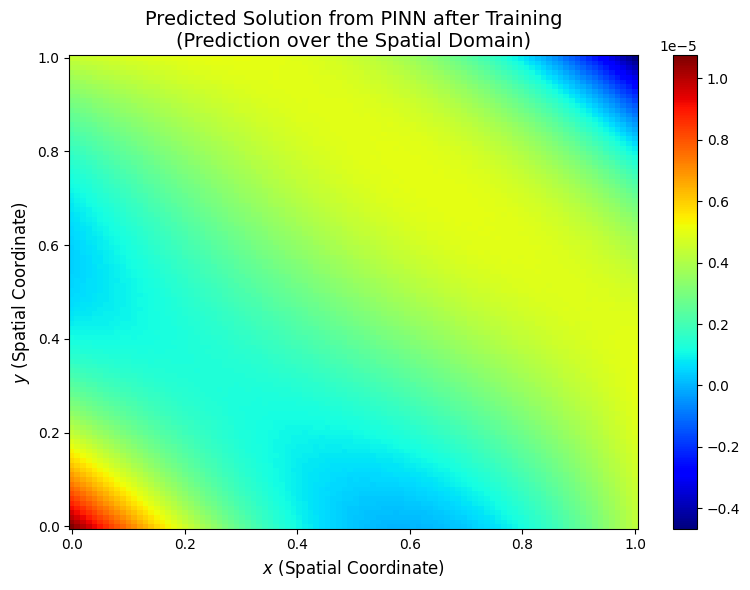

In [16]:
# Visualize solution
visualize_solution(model, x_train, y_train)

# Redo analysis with different training method

Epoch: 0/1000, Loss: 2.1156347429496236e-06, hbar: 1.0, m: 1.0, g: 1.0, Adaptive BC: 0.833541989326477
Epoch: 100/1000, Loss: 1.8624876929607126e-06, hbar: 1.0, m: 1.0, g: 1.0, Adaptive BC: 0.833541750907898
Epoch: 200/1000, Loss: 1.8295905874765594e-06, hbar: 1.0, m: 1.0, g: 1.0, Adaptive BC: 0.833541750907898
Epoch: 300/1000, Loss: 1.7893230506160762e-06, hbar: 1.0, m: 1.0, g: 1.0, Adaptive BC: 0.833541750907898
Epoch: 400/1000, Loss: 1.788697886695445e-06, hbar: 1.0, m: 1.0, g: 1.0, Adaptive BC: 0.833541750907898
Epoch: 500/1000, Loss: 1.7560091691848356e-06, hbar: 1.0, m: 1.0, g: 1.0, Adaptive BC: 0.833541750907898
Epoch: 600/1000, Loss: 1.7281407735936227e-06, hbar: 1.0, m: 1.0, g: 1.0, Adaptive BC: 0.833541750907898
Epoch: 700/1000, Loss: 1.707592559796467e-06, hbar: 1.0, m: 1.0, g: 1.0, Adaptive BC: 0.833541750907898
Epoch: 800/1000, Loss: 1.6758779111114563e-06, hbar: 1.0, m: 1.0, g: 1.0, Adaptive BC: 0.833541750907898
Epoch: 900/1000, Loss: 1.6551499584238627e-06, hbar: 1.0, m

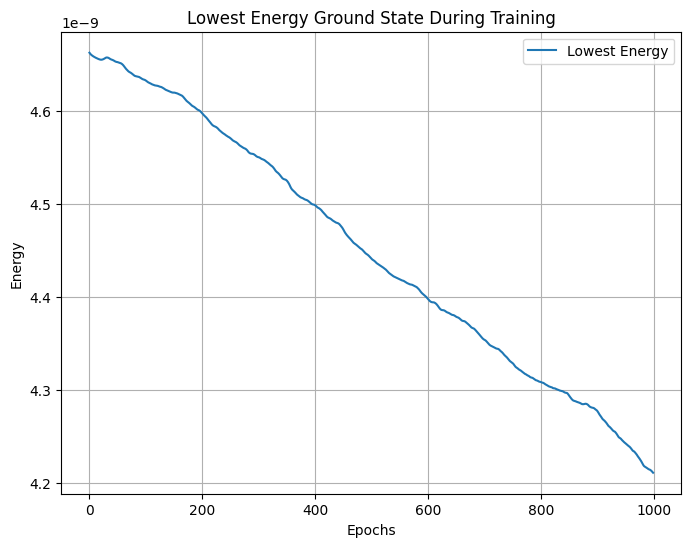

In [17]:
# Original training method
train_pinn_mixed_precision(model, adam_optimizer, scheduler, x_bc, y_bc, torch.cat([x_bc, y_bc], dim=1), epochs)

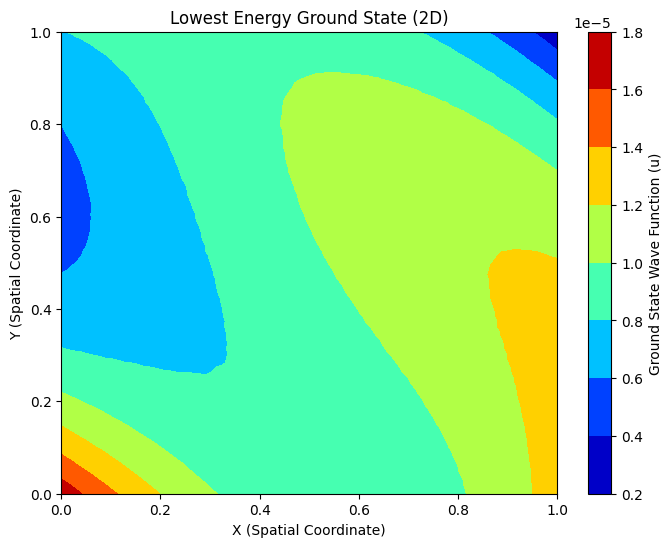

In [18]:
# Return lowest energy ground state (u as a vector and lambda as a scalar) and plot values
plot_ground_state_2d(model, x_train, y_train)

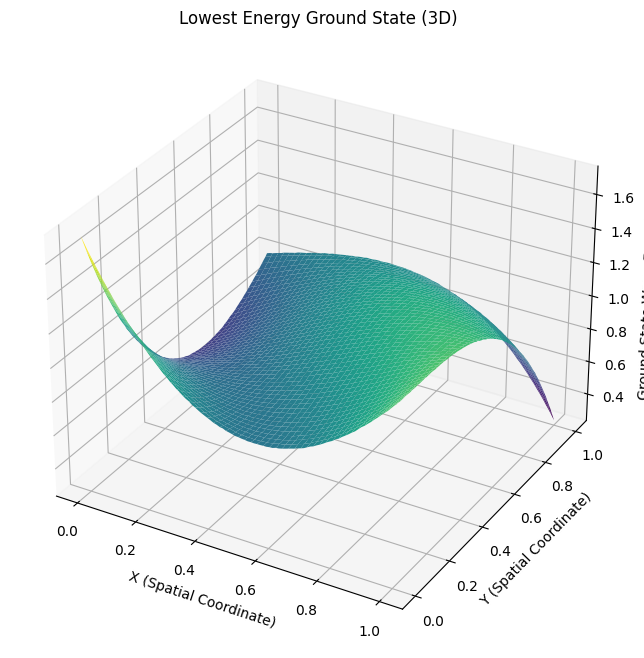

In [19]:
plot_ground_state_3d(model, x_train, y_train)

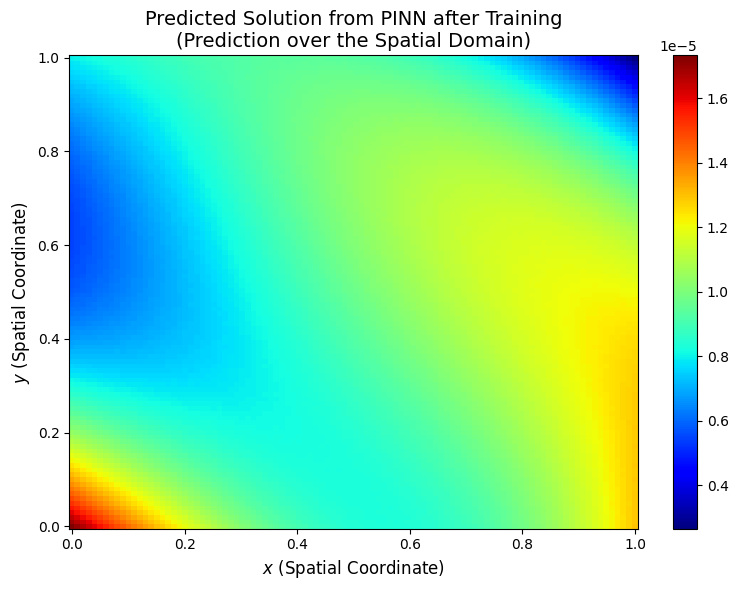

In [20]:
# Visualize solution
visualize_solution(model, x_train, y_train)